In [ ]:
!pip install torch_geometric
!pip install haversine
!pip install torchinfo

In [ ]:
import pandas as pd
import numpy as np
import datetime
import time
import torch
from torch_geometric.data import Data
from torch_geometric.nn import GATConv
from haversine import haversine
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import networkx as nx
import matplotlib.pyplot as plt
import folium
from folium.plugins import HeatMap


In [ ]:
# =============================================================================
# Data Loading and Preprocessing
# =============================================================================

# Define datatype specifications for CSV columns
dtypes = {
    'INC NUMBER': str,  # Preserve leading zeros
    'OCCURRED ON': str,
    'OCCURRED TO': str,
    'UCR CRIME CATEGORY': str,
    '100 BLOCK ADDR': str,
    'ZIP': float,       # Handle NaN ZIPs later
    'PREMISE TYPE': str,
    'GRID': str
}

In [ ]:
df = pd.read_csv("/content/crime-data_crime-data_crimestat.csv", dtype=dtypes, low_memory=False)


In [ ]:
# Convert date fields to datetime objects (errors are coerced to NaT)
df['OCCURRED ON'] = pd.to_datetime(df['OCCURRED ON'], errors='coerce')
df['OCCURRED TO'] = pd.to_datetime(df['OCCURRED TO'], errors='coerce')

# Drop any rows missing a valid ZIP or occurred date
df = df.dropna(subset=['ZIP', 'OCCURRED ON'])

# Format ZIP codes to be string with 5 digits (removing ".0" artifacts)
df['ZIP'] = df['ZIP'].astype(str).str.replace('\.0', '', regex=True).str.zfill(5)
df['ZIP'] = df['ZIP'].replace('nan', pd.NA)

In [ ]:
# Group data by ZIP and DATE (here we assume that the dates are grouped correctly)
# Adjust the column name for date as needed.
crime_counts = df.groupby(['ZIP', 'OCCURRED ON']).size().unstack(fill_value=0)

# Reset index to ensure a clean DataFrame structure
crime_counts = crime_counts.reset_index().drop(columns='index', errors='ignore')

# Identify date columns (only keep those that are dates)
date_columns = [col for col in crime_counts.columns if isinstance(col, (pd.Timestamp, datetime.date))]


In [ ]:
# Melt the DataFrame into a long format for easier feature extraction
crime_long = crime_counts.melt(
    id_vars=['ZIP'],
    value_vars=date_columns,
    var_name='DATE',
    value_name='CRIME_COUNT'
)
crime_long['DATE'] = pd.to_datetime(crime_long['DATE'])

# Add additional time-based features
crime_long['DAY_OF_WEEK'] = crime_long['DATE'].dt.dayofweek  # Monday=0, Sunday=6
crime_long['MONTH'] = crime_long['DATE'].dt.month
crime_long['IS_WEEKEND'] = crime_long['DAY_OF_WEEK'].isin([5, 6]).astype(int)
crime_long['YEAR'] = crime_long['DATE'].dt.year

In [ ]:
crime_long.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43796142 entries, 0 to 43796141
Data columns (total 9 columns):
 #   Column       Dtype         
---  ------       -----         
 0   ZIP          object        
 1   DATE         datetime64[ns]
 2   CRIME_COUNT  int64         
 3   DAY_OF_WEEK  int32         
 4   MONTH        int32         
 5   IS_WEEKEND   int64         
 6   YEAR         int32         
 7   LAT          float64       
 8   LON          float64       
dtypes: datetime64[ns](1), float64(2), int32(3), int64(2), object(1)
memory usage: 2.4+ GB


In [ ]:
# =============================================================================
# Geocoding: Obtaining ZIP Centroid Coordinates
# =============================================================================

from geopy.geocoders import Nominatim
geolocator = Nominatim(user_agent="zipcode_locator")

zip_centroids = {}

# Loop over unique ZIP codes to fetch latitude and longitude.
# (Delay each request to respect the service usage limits.)
for zipcode in crime_long['ZIP'].unique():
    try:
        location = geolocator.geocode({"postalcode": zipcode, "country": "US"}, timeout=10)
        if location:
            zip_centroids[zipcode] = (location.latitude, location.longitude)
        else:
            print(f"Coordinates not found for ZIP {zipcode}")
    except Exception as e:
        print(f"Error fetching coordinates for ZIP {zipcode}: {e}")
    time.sleep(5)

# Map centroid coordinates back to our long-format DataFrame
crime_long['LAT'] = crime_long['ZIP'].map(lambda x: zip_centroids.get(x, (np.nan, np.nan))[0])
crime_long['LON'] = crime_long['ZIP'].map(lambda x: zip_centroids.get(x, (np.nan, np.nan))[1])



In [ ]:
crime_long['CRIME_COUNT'].value_counts()

,count
CRIME_COUNT,
0,43234981
1,542144
2,16721
3,1844
4,336
5,80
6,26
7,6
24,1


In [ ]:
# =============================================================================
# Graph Construction and Node Feature Aggregation
# =============================================================================

# Aggregate node (ZIP) features: take mean crime count and other features
# You may include more aggregated statistics or extra features as needed.
features = ['CRIME_COUNT', 'DAY_OF_WEEK', 'MONTH', 'IS_WEEKEND', 'LAT', 'LON']
node_features = crime_long.groupby('ZIP')[features].mean()

# Ensure sorted order for consistent node indexing.
unique_zips = sorted(node_features.index.tolist())
node_features = node_features.loc[unique_zips].values  # Shape: (n_nodes, num_features)

In [ ]:
# =============================================================================
# Hotspot Labeling using Percentile
# =============================================================================

# Compute average daily crime count per ZIP
node_avg_crime = crime_long.groupby('ZIP')['CRIME_COUNT'].mean()

# Set threshold as the 55th percentile
percentile = 55
threshold_hotspot = np.percentile(node_avg_crime, percentile)

# Label hotspots
hotspot_labels = (node_avg_crime.loc[unique_zips] > threshold_hotspot).astype(int)

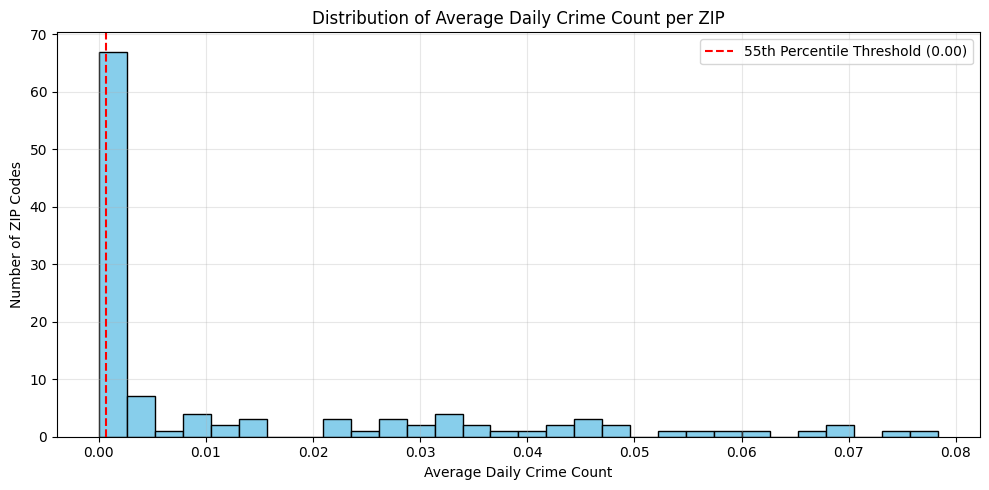

In [ ]:
import matplotlib.pyplot as plt

# Plot the histogram of average crime per ZIP code
plt.figure(figsize=(10, 5))
plt.hist(node_avg_crime, bins=30, color='skyblue', edgecolor='black')
plt.axvline(threshold_hotspot, color='red', linestyle='--', label=f'55th Percentile Threshold ({threshold_hotspot:.2f})')
plt.title('Distribution of Average Daily Crime Count per ZIP')
plt.xlabel('Average Daily Crime Count')
plt.ylabel('Number of ZIP Codes')
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


In [ ]:
hotspot_labels.value_counts()

,count
CRIME_COUNT,
0,64
1,53


In [ ]:
# =============================================================================
#  Creating the Graph: Use k-Nearest Neighbors (k-NN)
# =============================================================================

from sklearn.neighbors import NearestNeighbors

# Get lat/lon coordinates for each ZIP
coords = np.array([zip_centroids[z] for z in unique_zips])

# Create k-nearest neighbors graph
k = 5  # You can tune this
nbrs = NearestNeighbors(n_neighbors=k+1, metric='haversine').fit(np.radians(coords))
distances, indices = nbrs.kneighbors(np.radians(coords))

# Create edge list
edges = []
for i in range(len(unique_zips)):
    for j in indices[i][1:]:  # skip self (first index)
        edges.append([i, j])
        edges.append([j, i])

edge_index = torch.tensor(edges, dtype=torch.long).t().contiguous()


In [ ]:
# =============================================================================
# Preparing the PyTorch Geometric Data Object
# =============================================================================
data = Data(
    x=torch.tensor(node_features, dtype=torch.float),
    edge_index=edge_index,
    y=torch.tensor(hotspot_labels.values, dtype=torch.float)  # Binary labels for hotspot detection
)

# Create train/test masks by randomly splitting nodes (80% training, 20% testing)
n_nodes = data.x.shape[0]
indices = torch.randperm(n_nodes)
n_test = int(n_nodes * 0.2)
test_indices = indices[:n_test]
train_indices = indices[n_test:]

data.train_mask = torch.zeros(n_nodes, dtype=torch.bool)
data.test_mask = torch.zeros(n_nodes, dtype=torch.bool)
data.train_mask[train_indices] = True
data.test_mask[test_indices] = True


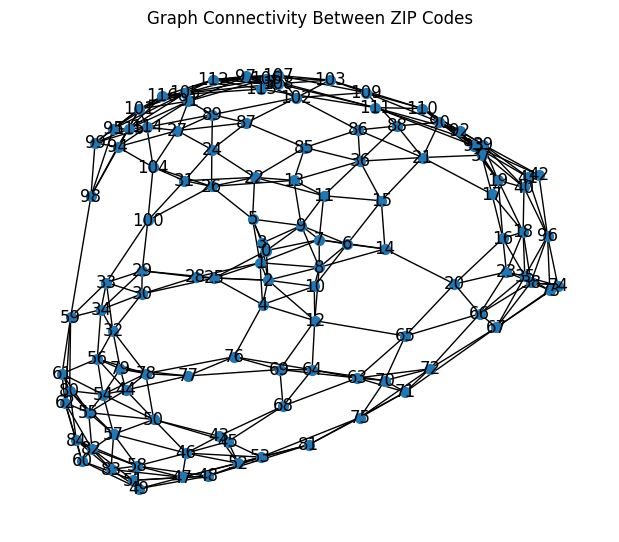

In [ ]:
# =============================================================================
# Visualizing the Graph
# =============================================================================
G = nx.Graph()
G.add_edges_from(edge_index.t().tolist())
plt.figure(figsize=(6, 5))
nx.draw(G, with_labels=True, node_size=50)
plt.title("Graph Connectivity Between ZIP Codes")
plt.show()

In [ ]:
# =============================================================================
# Model Definition: GNN for Crime Hotspot Detection (Binary Classification)
# =============================================================================

from torch_geometric.nn import GCNConv
import torch.nn.functional as F
import torch.nn as nn

class CrimeHotspotGNN(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim=32):
        super().__init__()
        self.conv1 = GCNConv(input_dim, hidden_dim)
        self.bn1 = nn.BatchNorm1d(hidden_dim)
        self.conv2 = GCNConv(hidden_dim, hidden_dim)
        self.bn2 = nn.BatchNorm1d(hidden_dim)
        self.dropout = nn.Dropout(0.3)
        self.out = nn.Linear(hidden_dim, 1)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x, edge_index)
        x = self.bn1(x)
        x = F.relu(x)
        x = self.conv2(x, edge_index)
        x = self.bn2(x)
        x = F.relu(x)
        x = self.dropout(x)
        x = self.out(x)
        return x.squeeze()

input_dim = data.x.shape[1]  # Should equal the number of features we computed
model = CrimeHotspotGNN(input_dim=input_dim)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
pos_weight = torch.tensor([data.y.sum() / (len(data.y) - data.y.sum())])
criterion = torch.nn.BCEWithLogitsLoss(pos_weight=pos_weight)

In [ ]:
from torchinfo import summary

# Use the model and access the data tensors
dummy_input = (data.x, data.edge_index)

# You must define a wrapper for summary to work
class WrappedModel(torch.nn.Module):
    def __init__(self, model):
        super().__init__()
        self.model = model
    def forward(self, x, edge_index):
        return self.model.forward(data)

wrapped = WrappedModel(model)

summary(wrapped, input_data=dummy_input, col_names=["input_size", "output_size", "num_params"])


Layer (type:depth-idx)                   Input Shape               Output Shape              Param #
WrappedModel                             [117, 6]                  [117]                     --
├─CrimeHotspotGNN: 1-1                   --                        --                        --
│    └─GCNConv: 2-1                      [117, 6]                  [117, 32]                 32
│    │    └─Linear: 3-1                  [117, 6]                  [117, 32]                 192
│    │    └─SumAggregation: 3-2          [1287, 32]                [117, 32]                 --
│    └─BatchNorm1d: 2-2                  [117, 32]                 [117, 32]                 64
│    └─GCNConv: 2-3                      [117, 32]                 [117, 32]                 32
│    │    └─Linear: 3-3                  [117, 32]                 [117, 32]                 1,024
│    │    └─SumAggregation: 3-4          [1287, 32]                [117, 32]                 --
│    └─BatchNorm1d: 2-4        

In [ ]:
# =============================================================================
# Training the GNN for Hotspot Detection
# =============================================================================

def train(model, data, epochs=100):
    model.train()
    losses = []
    for epoch in range(epochs):
        optimizer.zero_grad()
        out = model(data)
        loss = criterion(out[data.train_mask], data.y[data.train_mask])
        loss.backward()
        optimizer.step()
        losses.append(loss.item())
        print(f"Epoch {epoch+1:03d} | Loss: {loss.item():.4f}")
    return losses

train_losses = train(model, data, epochs=1000)

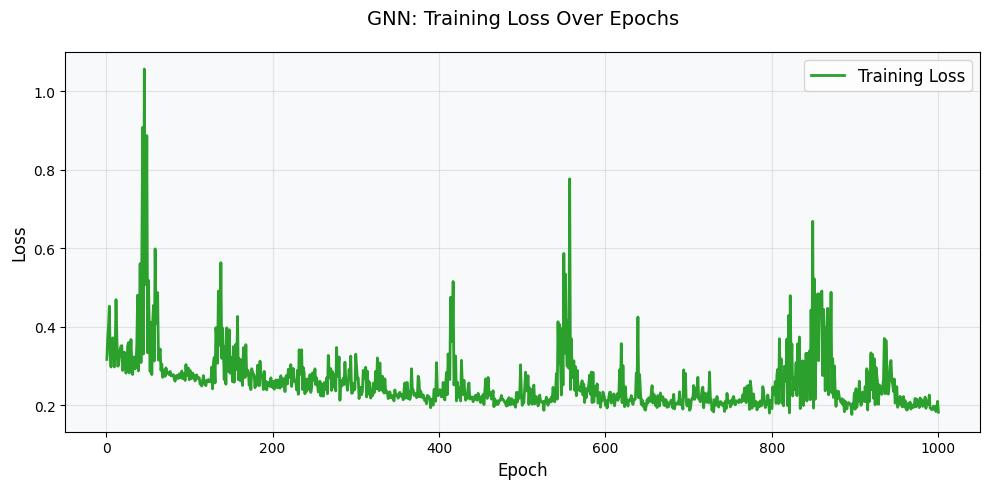

In [ ]:
import matplotlib.pyplot as plt

# Assuming train_losses is already defined from training your model.
# For example: train_losses = train(model, data, epochs=100)

# Create a figure with a specified size
plt.figure(figsize=(10, 5))

# Plot the training losses over epochs.
# We use a range starting from 1 to the number of epochs for proper labeling.
plt.plot(range(1, len(train_losses) + 1), train_losses,
         label='Training Loss',
         linewidth=2,
         color='#2ca02c')  # Using a greenish tone

# Add title and axis labels with increased font size for clarity.
plt.title('GNN: Training Loss Over Epochs', fontsize=14, pad=20)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Loss', fontsize=12)

# Add the legend to identify the training loss curve.
plt.legend(fontsize=12)

# Add grid lines with a bit of transparency.
plt.grid(True, alpha=0.3)

# Set the background color of the plotting area.
plt.gca().set_facecolor('#f8f9fa')

# Adjust layout to prevent clipping of labels/titles.
plt.tight_layout()

# Display the plot.
plt.show()


In [ ]:
# =============================================================================
# Evaluating the Hotspot Detection Model
# =============================================================================
def evaluate(model, data, threshold=0.5):
    model.eval()
    with torch.no_grad():
        # Get raw logits from the model and apply sigmoid to obtain probabilities.
        logits = model(data)
        probs = torch.sigmoid(logits)
        # Convert probabilities to binary predictions based on the threshold.
        preds = (probs >= threshold).float()

        # Extract the ground truth for test nodes.
        y_true = data.y[data.test_mask].cpu().numpy()
        y_pred = preds[data.test_mask].cpu().numpy()

        acc = accuracy_score(y_true, y_pred)
        report = classification_report(y_true, y_pred, target_names=['Non-Hotspot', 'Hotspot'])
        cm = confusion_matrix(y_true, y_pred)

        print(f"Accuracy: {acc:.4f}")
        print("Classification Report:")
        print(report)
        print("Confusion Matrix:")
        print(cm)

    return probs, preds

# Evaluate on the test nodes
probs, preds = evaluate(model, data, threshold=0.5)

Accuracy: 0.8696
Classification Report:
              precision    recall  f1-score   support

 Non-Hotspot       1.00      0.80      0.89        15
     Hotspot       0.73      1.00      0.84         8

    accuracy                           0.87        23
   macro avg       0.86      0.90      0.87        23
weighted avg       0.91      0.87      0.87        23

Confusion Matrix:
[[12  3]
 [ 0  8]]


In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(y_true, y_pred, title="Confusion Matrix"):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Non-Hotspot (0)', 'Hotspot (1)'],
                yticklabels=['Non-Hotspot (0)', 'Hotspot (1)'])
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title(title)
    plt.tight_layout()
    plt.show()


In [ ]:
from sklearn.metrics import roc_curve, auc

def plot_roc_curve(y_true, y_prob, title="ROC Curve"):
    fpr, tpr, _ = roc_curve(y_true, y_prob)
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'AUC = {roc_auc:.2f}')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(title)
    plt.legend(loc="lower right")
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()


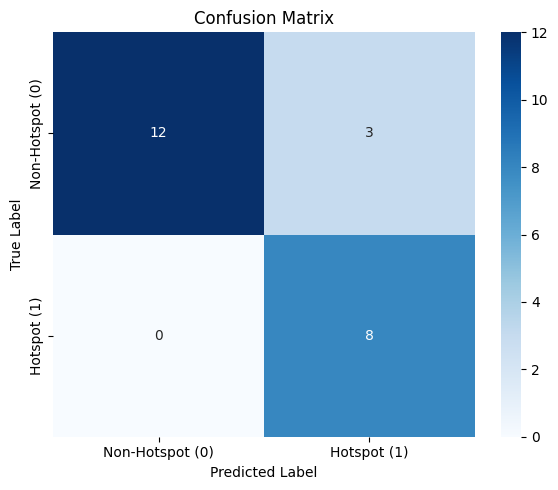

In [ ]:
model.eval()
with torch.no_grad():
    logits = model(data)
    y_prob = torch.sigmoid(logits[data.test_mask]).cpu().numpy()
    y_pred = (y_prob >= 0.5).astype(int)
    y_true = data.y[data.test_mask].cpu().numpy().astype(int)

plot_confusion_matrix(y_true, y_pred)

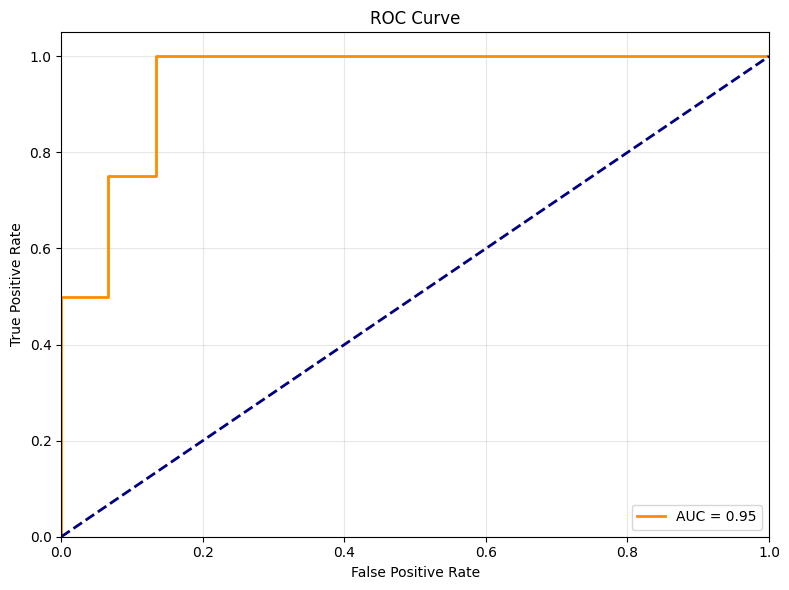

In [ ]:
plot_roc_curve(y_true, y_prob)

In [ ]:
# =============================================================================
#  Preparing Test Data Predictions for Visualization
# =============================================================================
# Build a DataFrame of results for nodes in the test set with actual labels, predicted probabilities, and coordinates.
test_node_indices = data.test_mask.nonzero(as_tuple=False).flatten().tolist()
results = []
for idx in test_node_indices:
    zip_code = unique_zips[idx]
    lat, lon = zip_centroids[zip_code]
    actual = data.y[idx].item()
    predicted_prob = torch.sigmoid(model(data)[idx]).item()
    predicted_label = 1 if predicted_prob >= 0.5 else 0
    results.append({
        'ZIP': zip_code,
        'LAT': lat,
        'LON': lon,
        'Actual': actual,
        'Predicted_Prob': predicted_prob,
        'Predicted_Label': predicted_label
    })

results_df = pd.DataFrame(results)
print("\nTest Results for Hotspot Detection:")
print(results_df)



Test Results for Hotspot Detection:
      ZIP        LAT         LON  Actual  Predicted_Prob  Predicted_Label
0   85008  33.469109 -112.000600     1.0        0.997604                1
1   85018  33.498186 -111.988244     1.0        0.971810                1
2   85022  33.629634 -112.051311     1.0        0.959229                1
3   85037  33.492159 -112.262012     1.0        0.931571                1
4   85041  33.376925 -112.098629     1.0        0.992377                1
5   85048  33.301566 -112.027346     1.0        0.879554                1
6   85085  33.754577 -112.105688     1.0        0.745415                1
7   85203  33.437641 -111.805315     0.0        0.096067                0
8   85210  33.377918 -111.847354     0.0        0.090530                0
9   85213  33.445280 -111.771971     0.0        0.097156                0
10  85215  33.464982 -111.723630     0.0        0.099552                0
11  85257  33.468448 -111.917992     0.0        0.472858                0
1

In [ ]:
# =============================================================================
# Visualizing Crime Hotspots on a Map with Folium
# =============================================================================
# Create a Folium map centered at a representative location (e.g., Phoenix)
phoenix_map = folium.Map(location=[33.4484, -112.0740], zoom_start=12)

# Define color gradients for visualization.
# Keys are now strings to avoid the AttributeError.
hotspot_gradient = {'0.4': 'blue', '0.6': 'lime', '1': 'red'}

# Prepare the heatmap data. The heatmap intensity uses the predicted probability.
heatmap_data = results_df[['LAT', 'LON', 'Predicted_Prob']].values.tolist()

# Add heatmap layer
HeatMap(
    data=heatmap_data,
    name='Hotspot Prediction',
    radius=15,
    gradient=hotspot_gradient,
    blur=10
).add_to(phoenix_map)

# Optionally, add markers that show detailed information per node.
for _, row in results_df.iterrows():
    popup_text = (f"ZIP: {row['ZIP']}<br>"
                  f"Actual: {row['Actual']}<br>"
                  f"Predicted Prob: {row['Predicted_Prob']:.2f}<br>"
                  f"Label: {'Hotspot' if row['Predicted_Label'] == 1 else 'Non-Hotspot'}")
    folium.CircleMarker(
        location=[row['LAT'], row['LON']],
        radius=5 + 10 * row['Predicted_Prob'],  # Scale radius by predicted probability
        popup=popup_text,
        color='black',
        fill=True,
        fill_color='orange' if row['Predicted_Label'] == 1 else 'green',
        weight=1
    ).add_to(phoenix_map)

# Add layer control and display the map.
folium.LayerControl().add_to(phoenix_map)
phoenix_map.save('phoenix_crime_hotspots.html')
phoenix_map  # This line displays the map in a Jupyter notebook.
